### **1. Import Libraries**

In [1]:

import re
import nltk
import string
import wordcloud
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from collections import defaultdict
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **2. Reading Dataset**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Sroor For Laptop\.cache\kagglehub\datasets\uciml\sms-spam-collection-dataset\versions\1


In [3]:
df = pd.read_csv(f"{path}/spam.csv", encoding='latin-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df = df[['v1','v2']]
df.columns = ['label','text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Display basic information**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
print("Number of missing values in each column:")
print(df.isnull().sum())

Number of missing values in each column:
label    0
text     0
dtype: int64


In [8]:
print("Number of spam messages:", df[df['label']=='spam'].shape[0])
print("Number of ham messages:", df[df['label']=='ham'].shape[0])

Number of spam messages: 747
Number of ham messages: 4825


In [9]:
# select random spam message
df[df['label']=='spam'].iloc[100]['text']

'To review and KEEP the fantastic Nokia N-Gage game deck with Club Nokia, go 2 www.cnupdates.com/newsletter. unsubscribe from alerts reply with the word OUT'

### **3. Visualization**

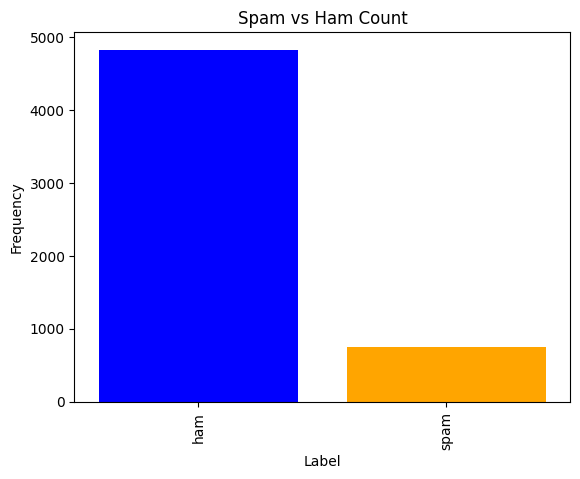

In [10]:
df['label'].value_counts().plot(kind='bar')
color = ['blue', 'orange']
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values, color=color)
plt.title('Spam vs Ham Count')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

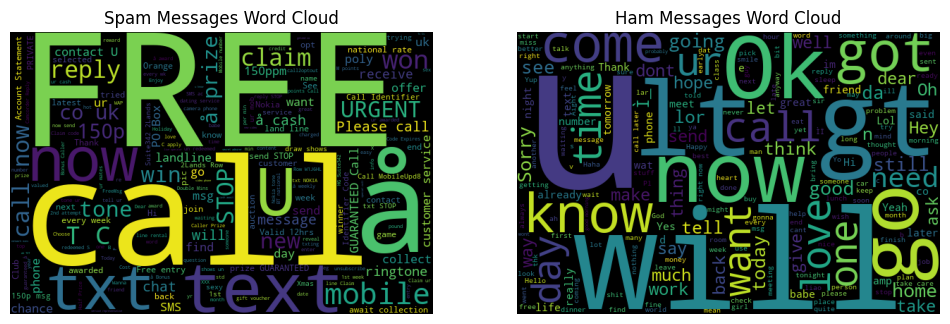

In [11]:
# worldcloud visualization
spam_words = ' '.join(list(df[df['label']=='spam']['text']))
ham_words = ' '.join(list(df[df['label']=='ham']['text']))
spam_wc = WordCloud(width=600, height=400).generate(spam_words)
ham_wc = WordCloud(width=600, height=400).generate(ham_words)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(spam_wc)
plt.title('Spam Messages Word Cloud')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ham_wc)
plt.title('Ham Messages Word Cloud')
plt.axis('off')
plt.show()

### **4. PREPROCESSING**

In [12]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # 3. Remove email addresses
    text = re.sub(r"\S+@\S+", "", text)

    # 4. Remove phone numbers
    text = re.sub(r"\b\d{7,}\b", "", text)

    # 5. Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # 6. Remove weird unicode artifacts
    text = re.sub(r"[^a-z\s]", "", text)

    # 7. Remove multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    # 8. Tokenize
    tokens = word_tokenize(text)

    # 9. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # 10. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens

In [13]:
df['clean_tokens'] = df['text'].apply(clean_text)

In [14]:
df.head()

,label,text,clean_tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]"


In [15]:
# Length of tokens for each SMS
df['num_tokens'] = df['clean_tokens'].apply(len)

# Check first 10 messages
df[['text', 'num_tokens', 'clean_tokens']].head(10)

,text,num_tokens,clean_tokens
0,"Go until jurong point, crazy.. Available only ...",16,"[go, jurong, point, crazy, available, bugis, n..."
1,Ok lar... Joking wif u oni...,6,"[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,20,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,U dun say so early hor... U c already then say...,9,"[u, dun, say, early, hor, u, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...",8,"[nah, dont, think, go, usf, life, around, though]"
5,FreeMsg Hey there darling it's been 3 week's n...,17,"[freemsg, hey, darling, week, word, back, id, ..."
6,Even my brother is not like to speak with me. ...,8,"[even, brother, like, speak, treat, like, aid,..."
7,As per your request 'Melle Melle (Oru Minnamin...,15,"[per, request, melle, melle, oru, minnaminungi..."
8,WINNER!! As a valued network customer you have...,15,"[winner, valued, network, customer, selected, ..."
9,Had your mobile 11 months or more? U R entitle...,16,"[mobile, month, u, r, entitled, update, latest..."


In [16]:
df['clean_tokens'].describe()

count                          5572
unique                         5065
top       [sorry, ill, call, later]
freq                             30
Name: clean_tokens, dtype: object

In [17]:
total_tokens = sum(df['num_tokens'])
print("Total tokens in dataset:", total_tokens)

Total tokens in dataset: 49403


In [18]:
all_tokens = [token for tokens in df['clean_tokens'] for token in tokens]
print("Number of tokens in flattened list:", len(all_tokens))

Number of tokens in flattened list: 49403


In [19]:
# 1. Extract features and labels
X = df['text']
y = df['label'].map({'ham': 0, 'spam': 1})

# -------------------------------------------------
# 2. Train-test split (stratified to keep imbalance)
# -------------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------------
# 3. TF-IDF vectorization
#    Fit on train ONLY ➝ transform test
# -----------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=clean_text)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

# -------------------------------------------------
# 4. Undersampling (apply on training only)
# -------------------------------------------------
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_vec, y_train)

d:\programs\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


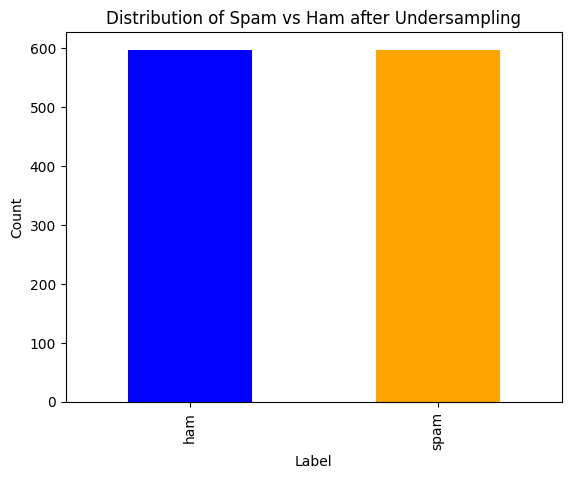

In [20]:
# visualize the new class distribution
resampled_counts = pd.Series(y_train_res).value_counts()
resampled_counts.index = resampled_counts.index.map({0: 'ham', 1: 'spam'})
resampled_counts.plot(kind='bar', color=color)
plt.title('Distribution of Spam vs Ham after Undersampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### **5. N-Gram Model & Markov Sentence Probability**

#### **Counting unigrams and bigrams**

In [21]:
# Calculate unigram and bigram counts
bigram_counts = defaultdict(lambda: defaultdict(int))
unigram_counts = defaultdict(int)

for tokens in df['clean_tokens']:
    for i, token in enumerate(tokens):
        unigram_counts[token] += 1
        if i > 0:
            bigram_counts[tokens[i-1]][token] += 1

 unigram_counts[token] → counts how many times each word appears in the dataset.

 bigram_counts[token1][token2] → counts how many times token2 follows token1.

 This builds the bigram probability table needed for a Markov model.

#### **Vocabulary size**

In [22]:
vocab_size = len(unigram_counts)
print("Vocabulary size (unique unigrams):", vocab_size)

Vocabulary size (unique unigrams): 7798


vocab_size is the total number of unique words in your corpus.

Needed for Laplace smoothing (add-1 smoothing) to avoid zero probabilities.

#### **Bigram probability function**

Calculates 

P(curr∣prev) using add-1 smoothing.

In [23]:
def bigram_prob(prev, curr):
    return (bigram_counts[prev][curr] + 1) / (unigram_counts[prev] + vocab_size)

#### *All words that appear after specific word anywhere in the dataset and its probability* 

In [27]:
def get_next_words_df(word, bigram_counts, unigram_counts):
    """
    Returns a pandas DataFrame containing:
      next_word | count | prob
    Sorted by frequency (count) descending.
    """
    if word not in bigram_counts:
        return pd.DataFrame(columns=["next_word", "count", "prob"]) # empty df if word not in bigrams

    next_words = bigram_counts[word] # dict of {next_word: count}
    total = sum(next_words.values()) # total frequency of "word" as previous token

    df = pd.DataFrame(
        [(w2, cnt, cnt / total) for w2, cnt in next_words.items()], # list of tuples (next_word, count, prob)
        columns=["next_word", "count", "prob"]
    )

    return df.sort_values("count", ascending=False).reset_index(drop=True)

In [28]:
# Get top words after "call"
top_words_after_call = get_next_words_df("call", bigram_counts, unigram_counts)

# Keep only top 10
top_10_df = top_words_after_call.head(10)

top_10_df

,next_word,count,prob
0,later,52,0.100193
1,landline,25,0.048170
2,claim,18,0.034682
3,land,18,0.034682
4,identifier,16,0.030829
5,mobileupd,15,0.028902
6,customer,15,0.028902
7,p,15,0.028902
8,u,12,0.023121
9,free,12,0.023121


In [29]:
# get top words after "free"
top_words_after_free = get_next_words_df("free", bigram_counts, unigram_counts)
top_words_after_free.head(10)

,next_word,count,prob
0,call,20,0.077220
1,text,18,0.069498
2,entry,16,0.061776
3,st,9,0.034749
4,camcorder,8,0.030888
5,auction,5,0.019305
6,bluetooth,5,0.019305
7,msg,5,0.019305
8,minute,5,0.019305
9,phone,4,0.015444


#### **Sentence probability function**

Computes the probability of a sentence under the bigram Markov assumption:

P(w1​,w2​,...,wn​)≈i=2∏n​P(wi​∣wi−1​)

Returns a very small number for long sentences (since probabilities < 1).

In [30]:
# Calculate sentence probability using bigram model
def sentence_probability(tokens):
    if len(tokens) < 2:
        return 0
    prob = 1
    for i in range(1, len(tokens)):
        prob *= bigram_prob(tokens[i-1], tokens[i])
    return prob

In [32]:
# printing the probability of a sample spam message
def print_message_probability(index):
    message = df.iloc[index]
    tokens = message['clean_tokens']
    prob = sentence_probability(tokens)
    print(f"Message: {message['text']}")
    print(f"Tokens: {tokens}")
    print(f"Probability: {prob}\n")

print_message_probability(100)  # example spam message

Message: Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx
Tokens: ['okay', 'name', 'ur', 'price', 'long', 'legal', 'wen', 'pick', 'u', 'ave', 'x', 'am', 'xx']
Probability: 5.7859280908524255e-43



In [33]:
# getting 10 random sentences from the dataset and their probabilities in a data frame
sentences = df['clean_tokens'].sample(10, random_state=42)

# data frame with sentences and their probabilities
results = []
for tokens in sentences:
    prob = sentence_probability(tokens)
    results.append((" ".join(tokens), prob))

In [34]:
df_probs = pd.DataFrame(results, columns=['Sentence', 'Markov Probability'])
df_probs

,Sentence,Markov Probability
0,funny fact nobody teach volcano erupt tsunami ...,8.862630e-62
1,sent score sophas secondary application school...,1.353938e-68
2,know someone know fancy call find pobox lshb p,1.339191e-28
3,promise getting soon youll text morning let kn...,9.091323e-32
4,congratulation ur awarded either cd gift vouch...,2.724035e-39
5,ill text carlos let know hang,1.258995e-16
6,ki didt see youkwhere,1.651471e-11
7,messageno responcewhat happend,2.629175e-07
8,get gandhipuram walk cross cut road right side...,1.849818e-47
9,flippin shit yet,6.546927e-08


In [35]:
# Keep only short messages (<= 6 words)
short_msgs = df['text'][df['text'].str.split().str.len() <= 6]

# Pick 10 random short messages
sample_sentences = short_msgs.sample(10, random_state=42).tolist()

In [36]:
sample_tokens = [clean_text(s) for s in sample_sentences]

In [37]:
# data frame with sentences and their probabilities

results = []
for tokens in sample_tokens:
    prob = sentence_probability(tokens)
    results.append((" ".join(tokens), prob))

df_probs_small = pd.DataFrame(results, columns=['Sentence', 'Markov Probability'])
df_probs_small


,Sentence,Markov Probability
0,like personal sized,6.372717e-08
1,sent like,3.813883e-04
2,say thanks,2.526529e-04
3,holding,0.000000e+00
4,india take lead,9.676879e-08
5,prabhaim sorydarealyfrm heart im sory,6.484882e-14
6,still attending da talk,1.626677e-11
7,got called tool,6.346011e-08
8,ok thanx take care,6.453870e-10
9,annoying isnt,2.564103e-04


### **6. Machine Learning Models (NB & SVM)**

### spliting the data 

In [38]:
# already done in previous cells 

### Train Naive Bayes

In [40]:
nb = MultinomialNB()
nb.fit(X_train_res , y_train_res)
pred_nb = nb.predict(X_test_vec)

print("Naive Bayes Accuracy:", accuracy_score(y_test, pred_nb))
print(classification_report(y_test, pred_nb))

Naive Bayes Accuracy: 0.9147982062780269
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       966
           1       0.62      0.96      0.75       149

    accuracy                           0.91      1115
   macro avg       0.80      0.93      0.85      1115
weighted avg       0.94      0.91      0.92      1115



### Train Linear SVM

In [44]:
svc = LinearSVC(class_weight='balanced')
svc.fit(X_train_res, y_train_res)  

pred_svm = svc.predict(X_test_vec)

print("SVM Accuracy:", accuracy_score(y_test, pred_svm))
print(classification_report(y_test, pred_svm))

SVM Accuracy: 0.967713004484305
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       966
           1       0.86      0.91      0.88       149

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



### **Confusion Matrix (SVM)**

Confusion Matrix:
 [[943  23]
 [ 13 136]]


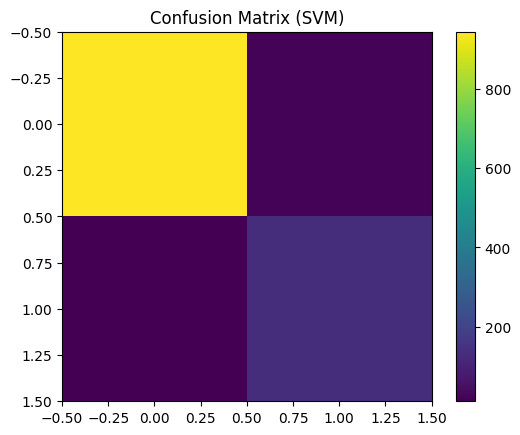

In [45]:
cm = confusion_matrix(y_test, pred_svm)
print("Confusion Matrix:\n", cm)
plt.imshow(cm)
plt.title("Confusion Matrix (SVM)")
plt.colorbar()
plt.show()